In [48]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import numpy as np

import torch
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm.auto import tqdm

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(project_root)

from models import AttentionVNet, VNet
from lit_models import LitBaseVNet
from dataloader import ProstateDataModule, download_and_extract_msd_prostate

torch.set_float32_matmul_precision('medium')

DATA_ROOT = "../data"

In [29]:
download_and_extract_msd_prostate(DATA_ROOT)

dm = ProstateDataModule(
	root_dir='./data/Task05_Prostate', 
	batch_size=1,
	roi_size=(128, 128, 64),
	num_workers=4,
	cache_dataset=True
)

dm.setup()

[dataloader.py] Downloading: https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar
[dataloader.py] Saved: ./data/Task05_Prostate/Task05_Prostate.tar
[dataloader.py] Extracting tar to: ./data/Task05_Prostate


Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 16.80it/s]


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 16.70it/s]


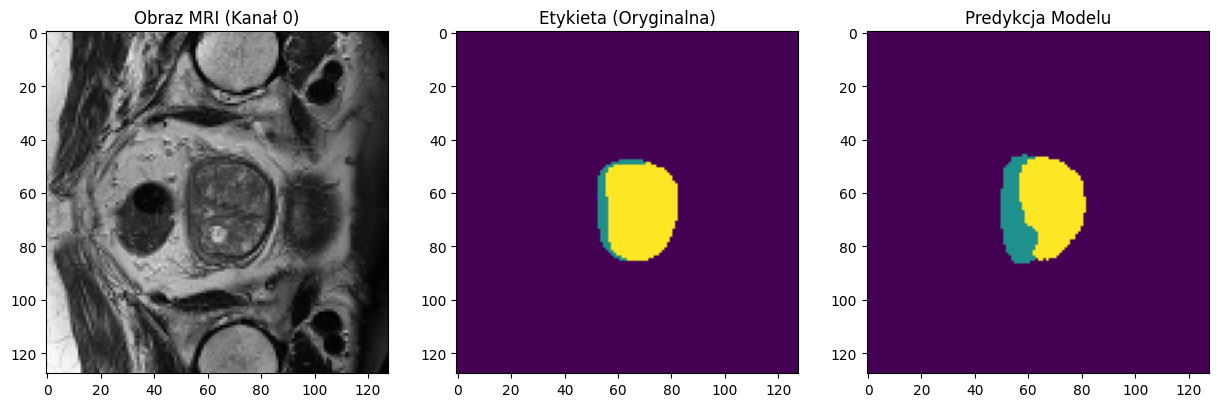

In [43]:
checkpoint_path = "../checkpoints/run_17/best-attention-vnet-epoch=194-val_dice=0.567.ckpt"

model = LitBaseVNet.load_from_checkpoint(
    checkpoint_path, 
    model_obj=AttentionVNet(in_ch=2, out_ch=3, base_channels=24)
)
model.eval()
model.cuda()

dm.setup(stage="train") 
train_loader = dm.train_dataloader()
batch = next(iter(train_loader))


x, y = model._prepare_batch(batch)
x = x.cuda()

with torch.no_grad():
    logits = model(x)
    preds = torch.argmax(logits, dim=1)

slice_idx = 32 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz MRI (Kanał 0)")
plt.imshow(x[0, 0, :, :, slice_idx].cpu(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Etykieta (Oryginalna)")
plt.imshow(y[0, 0, :, :, slice_idx].cpu())

plt.subplot(1, 3, 3)
plt.title("Predykcja Modelu")
plt.imshow(preds[0, :, :, slice_idx].cpu())

plt.show()

In [51]:
y_true = y.cpu().numpy()
y_pred = preds.cpu().numpy()

y_true = y_true[:, 0]

y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

cm = confusion_matrix(
    y_true_flat,
    y_pred_flat,
    labels=[0, 1, 2]
)

print("Macierz pomyłek (wiersze = GT, kolumny = predykcja):")
print(cm)

Macierz pomyłek (wiersze = GT, kolumny = predykcja):
[[1024650    2547     292]
 [     89    2062      81]
 [   2648    1418   14789]]


/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.6, which is newer than your current Lightning version: v2.5.5
/home/patryk/Desktop/venv/ML_venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 17.11it/s]


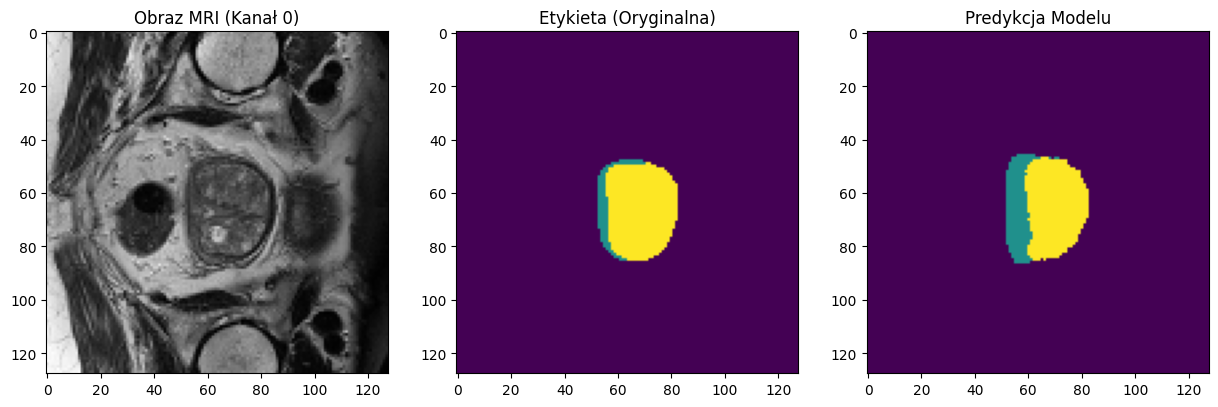

In [52]:
checkpoint_path = "../checkpoints_vnet/run_2/best-vnet-epoch=194-val_dice=0.580.ckpt"

model = LitBaseVNet.load_from_checkpoint(
    checkpoint_path, 
    model_obj=VNet(in_ch=2, out_ch=3, base_channels=24)
)
model.eval()
model.cuda()

dm.setup(stage="train") 
train_loader = dm.train_dataloader()
batch = next(iter(train_loader))


x, y = model._prepare_batch(batch)
x = x.cuda()

with torch.no_grad():
    logits = model(x)
    preds = torch.argmax(logits, dim=1)

slice_idx = 32 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz MRI (Kanał 0)")
plt.imshow(x[0, 0, :, :, slice_idx].cpu(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Etykieta (Oryginalna)")
plt.imshow(y[0, 0, :, :, slice_idx].cpu())

plt.subplot(1, 3, 3)
plt.title("Predykcja Modelu")
plt.imshow(preds[0, :, :, slice_idx].cpu())

plt.show()

In [53]:
y_true = y.cpu().numpy()
y_pred = preds.cpu().numpy()

y_true = y_true[:, 0]

y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

cm = confusion_matrix(
    y_true_flat,
    y_pred_flat,
    labels=[0, 1, 2]
)

print("Macierz pomyłek (wiersze = GT, kolumny = predykcja):")
print(cm)

Macierz pomyłek (wiersze = GT, kolumny = predykcja):
[[1024687    1846     956]
 [    135    1967     130]
 [   1638    1805   15412]]
